# Für welche Berufe werden Bewerber gesucht?

Im Nachgang soll eine Analyse gemacht werden, für welche Berufe Bewerber gesucht werden.
Dies trifft auch eine Aussage darüber aus, welche Art von Fachkräften in den USA aktuell gesucht werden.

Die hierfür notwendigen Informationen befinden sich in der Spalte `prevailing_wage_job_title_9089`des bereinigten Datensatzes.

In [68]:
import cleanup
import modules
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gc
plt.style.use('../own_style.mplstyle')

In [69]:
# Falls der bereinigte Datensatz noch nicht vorliegt:
#cleanup.generate_cleaned_df("../data/us_perm_visas.csv", "../data/")




In [70]:
col_list = [ "prevailing_wage_job_title_9089", "country_of_citizenship"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

Werfen wir einen Blick auf die Eingangsdaten:

In [71]:
visas_df['prevailing_wage_job_title_9089'].head(20)

0              computer software engineers, application
1                                      asbestos handler
2                                        civil engineer
3                                            file clerk
4                              sales & service engineer
5                    hazardous materials removal worker
6     secondary school teachers, except special and ...
7                                        cost estimator
8                              computer systems analyst
9                                    supervisor/manager
10                                  computer programmer
11                          public relations specialist
12                                  electronic engineer
13        network systems & data communications analyst
14                           brickmasons and blockmason
15               painters, construction and maintenance
16                                      systems analyst
17                                   retail sale

Die Eingangsdaten erscheinen noch nicht für eine Analyse geeignet.
Oft wurden nach einem Komma Spezifizierungen zu einem Beruf festgehalten.
Da im Sinne der Analyse generalisiert werden soll, werden wir die Strings auf den ersten Teil vor dem Komma kürzen.

In [72]:
unique_values_initial = visas_df['prevailing_wage_job_title_9089'].nunique()
print(unique_values_initial)

11749


In [73]:
visas_df['prevailing_wage_job_title_9089'] = visas_df['prevailing_wage_job_title_9089'].astype(str).str.split(',').str[0]


In [74]:
visas_df['prevailing_wage_job_title_9089'].nunique()

10274

In [75]:
visas_df['prevailing_wage_job_title_9089'].head(20)

0                       computer software engineers
1                                  asbestos handler
2                                    civil engineer
3                                        file clerk
4                          sales & service engineer
5                hazardous materials removal worker
6                         secondary school teachers
7                                    cost estimator
8                          computer systems analyst
9                                supervisor/manager
10                              computer programmer
11                      public relations specialist
12                              electronic engineer
13    network systems & data communications analyst
14                       brickmasons and blockmason
15                                         painters
16                                  systems analyst
17                               retail salesperson
18                                           bakers
19          

Nachdem die Strings nun auf den ersten Teil vor dem Komma gekürzt wurden, müssen wir die Bereinigung erneut vornehmen.
Wir werden dafür einzelne Bausteine der cleanup.py direkt aufrufen.

In [76]:
visas_df['prevailing_wage_job_title_9089'].str.strip().str[-1].value_counts()

s    180944
r    100338
t     72701
n      9481
k      2824
e      2717
y       991
g       984
c       526
)       526
i       472
f       403
l       390
d       325
a       241
h       120
m       104
.        56
p        55
o        32
v        30
3        28
2        16
x        13
w        10
4         7
1         7
*         3
b         3
0         3
]         3
u         2
6         2
5         2
?         1
&         1
+         1
Name: prevailing_wage_job_title_9089, dtype: int64

Es ist zu sehen, dass vereinzelt noch unübliche Satzzeichen als letztes Zeichen des Jobtitels verotert werden können.
Als unübliche Zeichen verstehen wir unter anderem *,?+.

Um dies zu bereinigen werden wir einzelne Funktionen aus der cleanup.py erneut ausführen.

In [77]:
#Unübliche Zeichen entfernen
visas_df['prevailing_wage_job_title_9089'] = cleanup.cutOffUnusualCharacters(visas_df['prevailing_wage_job_title_9089'])

In [78]:
#Plural zu Singular umwandeln
visas_df['prevailing_wage_job_title_9089'] = visas_df['prevailing_wage_job_title_9089'] .apply(cleanup.cutOfflastCharacter, stringToCutOff = "s")

In [79]:
print("Datensatz konnte um " + str(unique_values_initial - visas_df['prevailing_wage_job_title_9089'].nunique()) + " einzigartige Werte gekürzt werden.")
del unique_values_initial

Datensatz konnte um 1680 einzigartige Werte gekürzt werden.


Es folgt eine einfache Auswertung zu den am meisten vorkommenden Jobtiteln.

<AxesSubplot:title={'center':'Number of Visa Applications by Job Title'}, xlabel='Job Title', ylabel='Number of Visa Applications'>

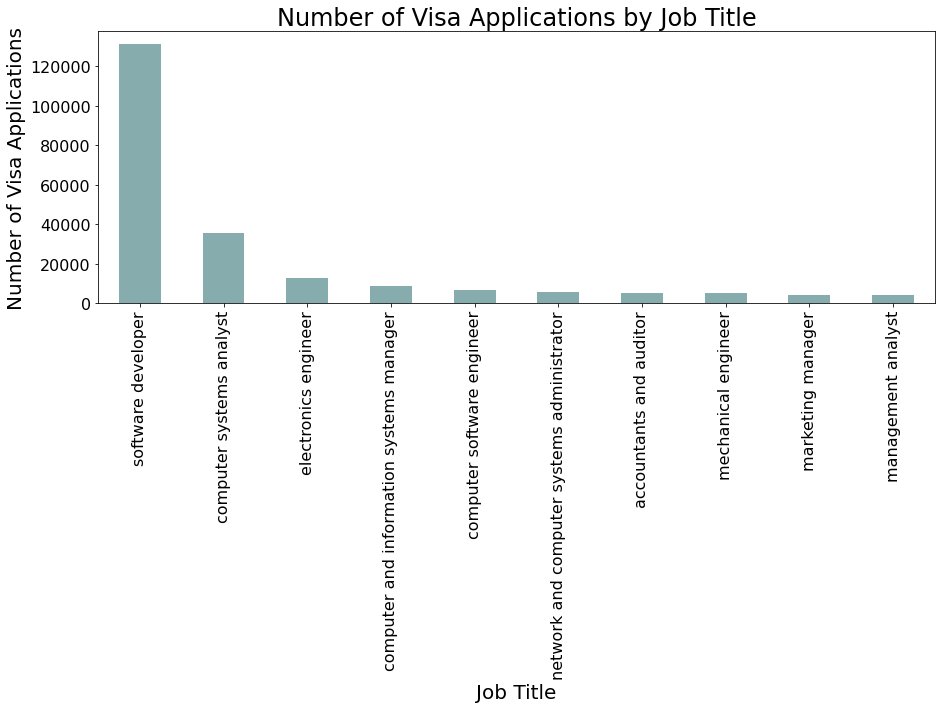

In [80]:
visas_df['prevailing_wage_job_title_9089'].value_counts()[:10].plot(kind="bar", xlabel="Job Title", ylabel = "Number of Visa Applications", title = "Number of Visa Applications by Job Title", figsize = [15,5])


In [81]:
visas_df['prevailing_wage_job_title_9089'].value_counts()[:20]


software developer                                   131120
computer systems analyst                              35527
electronics engineer                                  12922
computer and information systems manager               8907
computer software engineer                             6840
network and computer systems administrator             5879
accountants and auditor                                5238
mechanical engineer                                    5100
marketing manager                                      4193
management analyst                                     4121
database administrator                                 4053
financial analyst                                      3974
meat                                                   3857
internist                                              3794
electrical engineer                                    3715
statistician                                           3306
financial manager                       

Wir wissen nun, welche Jobtitel am häufigsten im Datensatz vertreten sind. Manche Jobtitel beschreiben ähnliche Arbeitsfelder, wie beispielsweise der electrical engineer und der industrial engineer.
Im Folgenden wollen wir die Jobtitel auf am häufigsten vorkommende Wörte analyisieren. Dafür laden wir alle Wörter in einen einzelnen String.

Der kreierte String `jobTitleString` wird für die nachfolgende Wordcloud benötigt.

In [82]:
jobTitleString = visas_df["prevailing_wage_job_title_9089"].str.cat(sep=' ')

In [83]:
type(jobTitleString)

str

In [84]:
jobTitleString_df = jobTitleString.split(' ')

In [85]:
jobTitleString_df = pd.DataFrame(jobTitleString_df)

In [86]:
jobTitleString_df.value_counts()[:20]

software         142269
developer        133049
computer          65509
systems           52105
analyst           51573
and               47866
engineer          46423
manager           27514
electronics       13181
teacher           12727
information       11657
administrator     10985
financial          7453
marketing          7447
network            7095
research           6106
meat               5475
auditor            5465
specialist         5405
mechanical         5346
dtype: int64

Am häufigsten kommen die Wörter software, developer und computer vor. Dies bestätigt die Erwartungen, nachdem viele Bewerber für den Einsatz im IT Sektor gewonnen werden.

In [87]:
#Es kommt häufig zu großen Arbeitsspeicherauslaustungen (Out of Memory). Durch die Löschung von Variablen hoffen wird die Performance etwas steigern zu können.
#del jobTitleString_df
gc.collect()

143

Mithilfe eriner WordCloud, wollen wir die oben generierte Erkentnisse noch visualisieren.
Das Attribut `collocations` bestimmt, ob Kollokationen (Bigramme) von zwei Wörtern aufgenommen werden sollen.

Wir beginnen mit deaktivierten collocations.

In [88]:
# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                collocations=False).generate(jobTitleString)

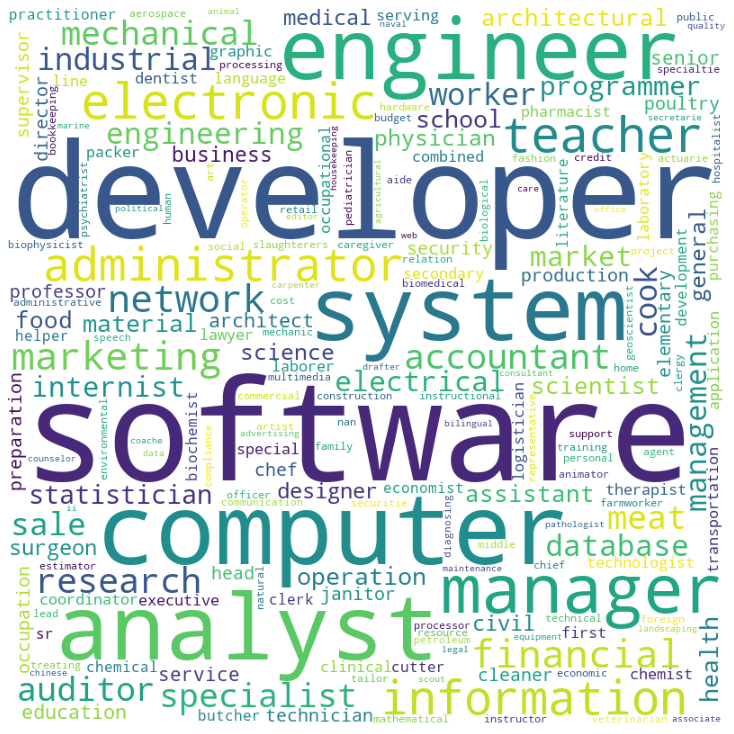

In [89]:

# Displaying the WordCloud
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(final_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Nun mit aktivierten collocations.

In [90]:
# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(jobTitleString)

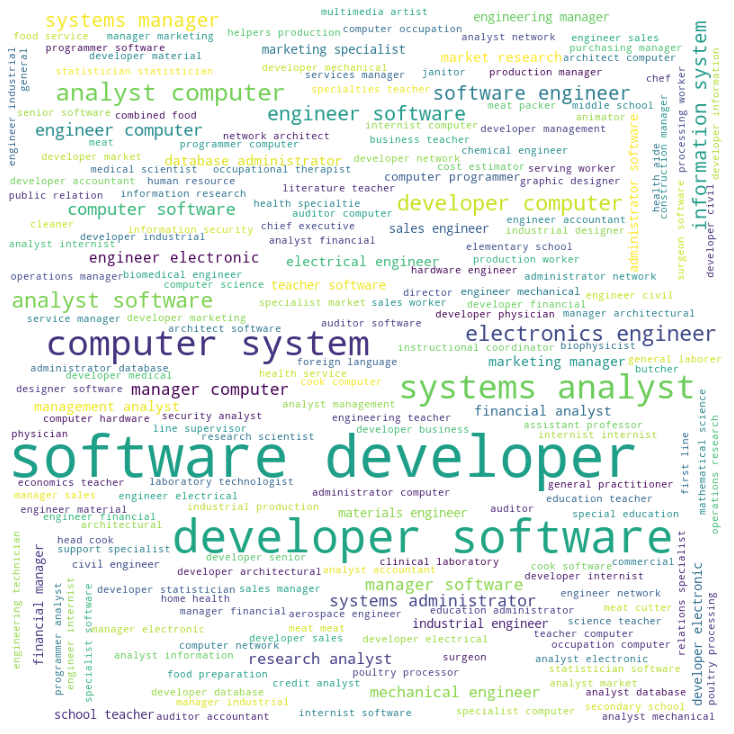

In [91]:

# Displaying the WordCloud
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(final_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [92]:
del final_wordcloud
del jobTitleString
gc.collect()

5519

Zum Abschluss soll noch nachgesehen werden, ob es gegebenenfalls Zusammenhänge zwischen dem Herkuftsland und den angestrebten Berufen gibt.
Dafür werden die 20 am häufigsten vorkommenden Herkunftsländer mit den 15 am häufigst vorkommenden Berufen in Beziehung gesetzt.

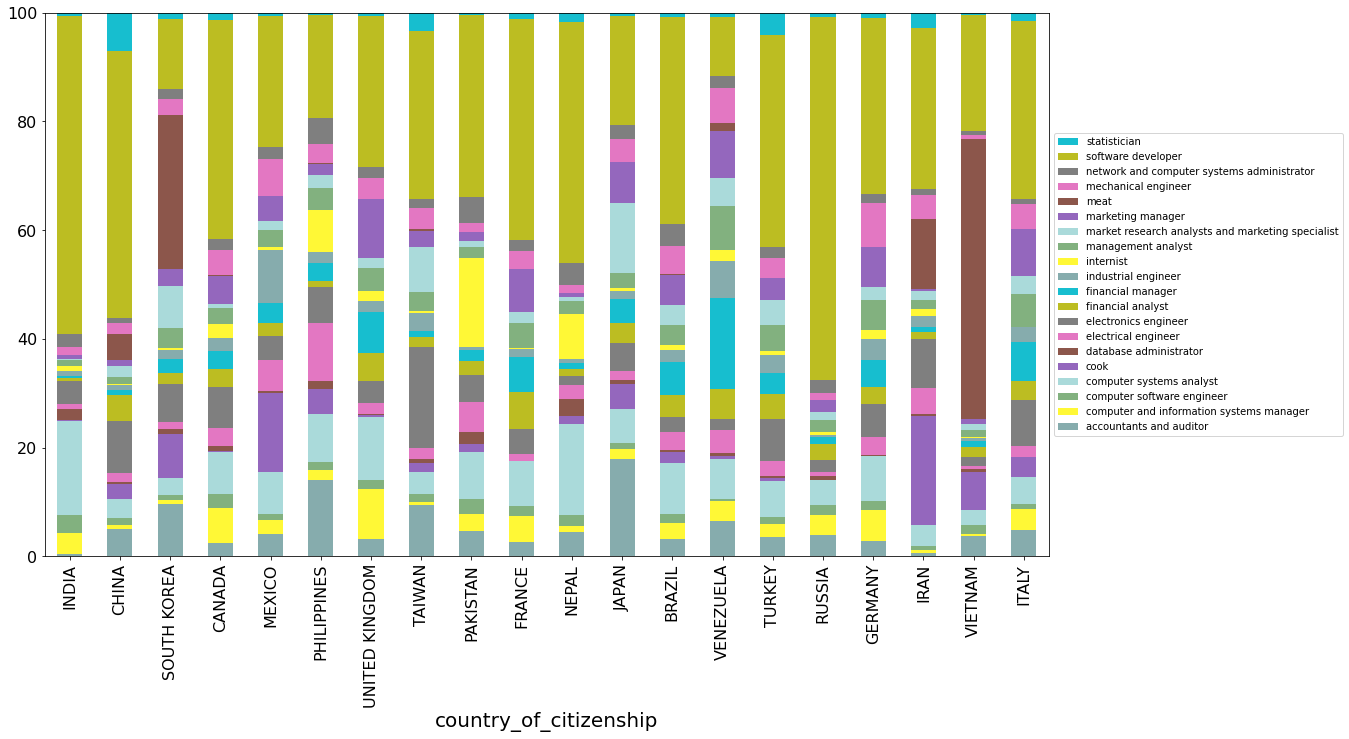

In [93]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "country_of_citizenship", "prevailing_wage_job_title_9089", 20, 20)

Leider ist es schwer, dass trotz erkennbarer Konzentrationstendenzen weitere belegbare Erkenntnisse abzuleiten.
